In [25]:
# Imports
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau # scheduler
from torch.optim import  Adam # optimizer
from torch.nn import CrossEntropyLoss # loss criterion
import copy


import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directories to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

In [26]:
# Setting gpu
torch.cuda.empty_cache()
device = torch.device("cuda")

In [27]:
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 10
train_size = 0.8
image_size = 64

train_loader, test_loader = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

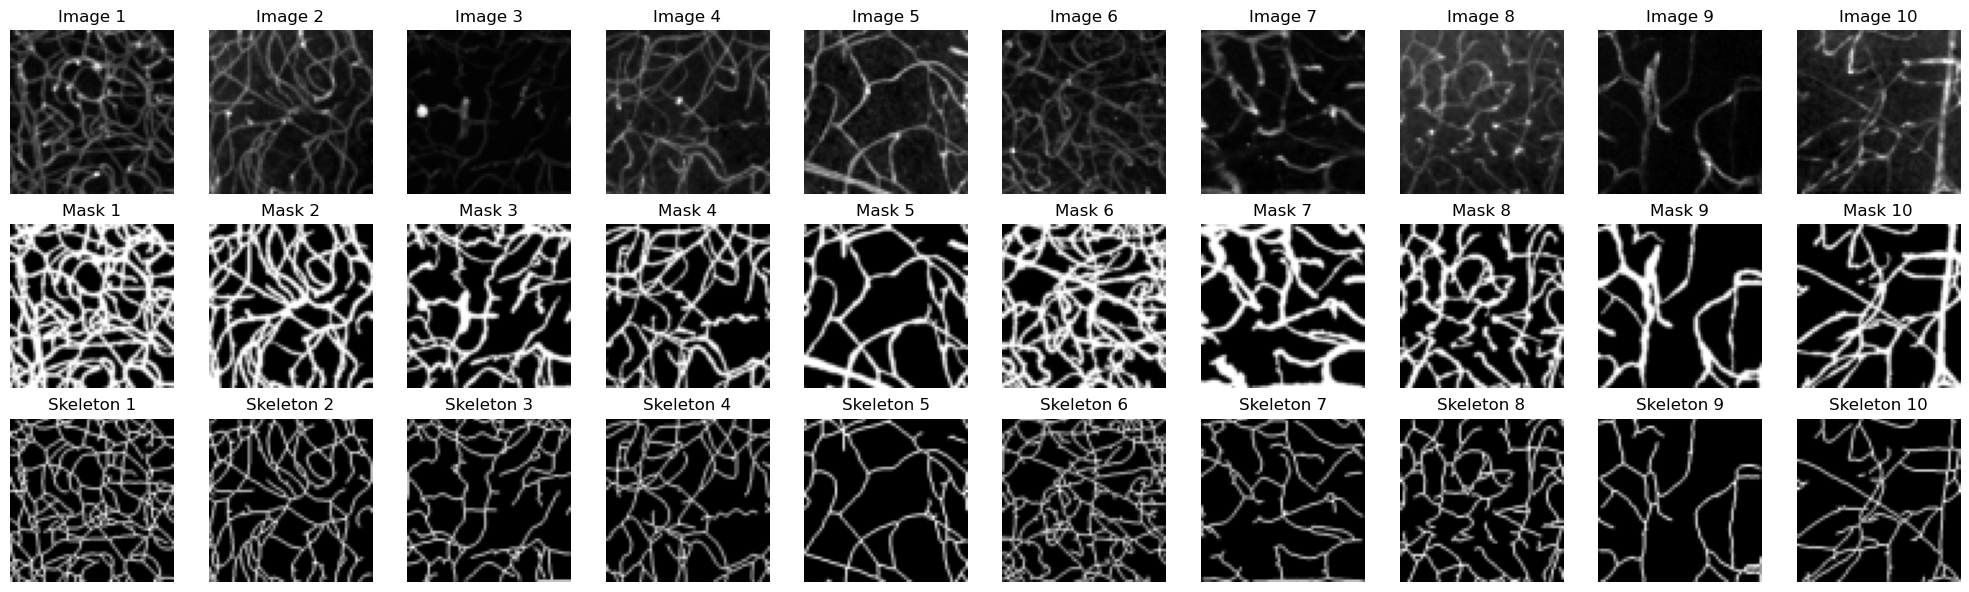

In [28]:
def show_images(data_loader, num_sets=10):
    fig, axs = plt.subplots(3, num_sets, figsize=(20, 6)) # 3 rows for images, masks, and skeletons, and num_sets columns

    # Initialize a counter for the number of sets displayed
    num_displayed = 0

    for images, masks, skeletons in data_loader:
        for i in range(images.size(0)):
            if num_displayed >= num_sets:
                break

            # Plotting image
            axs[0, num_displayed].imshow(images[i].permute(1, 2, 0), cmap='gray') # Rearrange dimensions to HWC for display
            axs[0, num_displayed].axis('off')
            axs[0, num_displayed].set_title(f'Image {num_displayed+1}')

            # Plotting mask
            axs[1, num_displayed].imshow(masks[i].squeeze(), cmap='gray') # Assuming mask is single-channel
            axs[1, num_displayed].axis('off')
            axs[1, num_displayed].set_title(f'Mask {num_displayed+1}')

            # Plotting skeleton
            axs[2, num_displayed].imshow(skeletons[i].squeeze(), cmap='gray') # Assuming skeleton is single-channel
            axs[2, num_displayed].axis('off')
            axs[2, num_displayed].set_title(f'Skeleton {num_displayed+1}')

            num_displayed += 1

        if num_displayed >= num_sets:
            break

    plt.tight_layout()
    plt.show()

# Call the function
show_images(train_loader, num_sets=10)

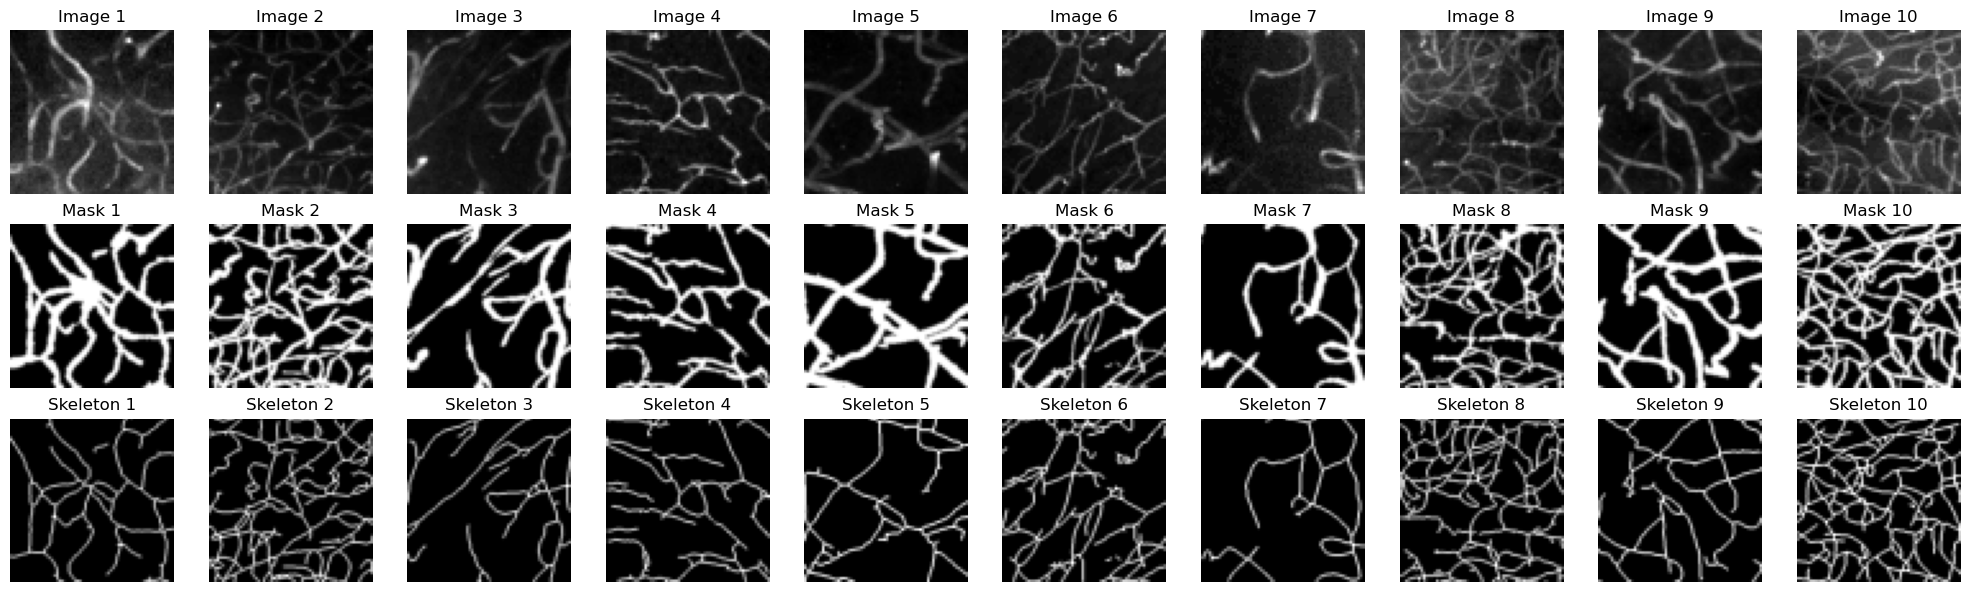

In [29]:
show_images(test_loader, num_sets=10)

In [30]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def sum_params(model, mode='l2'):
    s = 0
    for param in model.parameters():
        if mode == 'l2':
            s += (param ** 2).sum()
        else:
            s += param.abs().sum()
    return s

In [31]:
# Auxiliary Functions
def get_all_gradients(model, image, sampling_rate=1, device="cuda", vectorize=False):

    model.to(device)
    model = model.eval()
    model_wrapped = wrapper(model)
    sampled_image = image[:,::sampling_rate,::sampling_rate]
    sampled_image = sampled_image.to(device).unsqueeze(0)
    sampled_image.requires_grad = True

    jacobian = torch.autograd.functional.jacobian(model_wrapped, 
                                                            sampled_image,
                                                            vectorize = vectorize)
    jacobian = jacobian.squeeze().to('cpu')
    return jacobian

def wrapper(model):
    '''Wrap model to return probabilities and only the vessel channel.'''
    def new_model(img):
        out = model(img)
        probs = F.softmax(out, dim=1)
        return probs[:,1]
    return new_model


def jacobian_activation(jacobian_gradient):  
    dimension = jacobian_gradient.shape[0]
    map = jacobian_gradient.permute(2, 3, 0, 1).reshape(dimension, dimension, dimension*dimension).cuda()
    #avg_activation = torch.mean(map, dim=2).values
    max_activation = torch.max(map, dim=2).values
    
    return max_activation

def plot_metrics(train_losses, test_losses, train_ious, test_ious, optimization_epochs=0, title=''):
    plt.figure(figsize=(23, 11))

    # Subplot 1: Losses
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(test_losses, label='Test Loss', color='red')
    if optimization_epochs > 0:  # Plot scatter at every optimization_epochs
        ax1.scatter(range(0, len(train_losses), optimization_epochs), [train_losses[i] for i in range(0, len(train_losses), optimization_epochs)], color='blue')
        ax1.scatter(range(0, len(test_losses), optimization_epochs), [test_losses[i] for i in range(0, len(test_losses), optimization_epochs)], color='red')
    ax1.set_title('Train vs Test Losses' + title)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Subplot 2: IoUs
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(train_ious, label='Train IoU', color='green')
    ax2.plot(test_ious, label='Test IoU', color='purple')
    if optimization_epochs > 0:  # Plot scatter at every optimization_epochs
        ax2.scatter(range(0, len(train_ious), optimization_epochs), [train_ious[i] for i in range(0, len(train_ious), optimization_epochs)], color='green')
        ax2.scatter(range(0, len(test_ious), optimization_epochs), [test_ious[i] for i in range(0, len(test_ious), optimization_epochs)], color='purple')
    ax2.set_title('Train vs Test IoU' + title)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('IoU')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [32]:
# TODO: train with 224x224 -> doesnt improve much
# TODO: copy old train  loop and try to train -> doesnt improve much
# TODO: change batch size and try other parameters -> doesnt improve much
# TODO: try with and without scheduler and save lr changes over time -> helps in some epochs but doesnt improve much, reduce the learning rate make the most of the difference
# TODO: apply data augmentation, check notebook 1 do modulo 7

In [33]:
def training_loop(
    model,
    train_loader,
    test_loader,
    num_epochs,
    train_losses,
    test_losses,
    test_accuracies,
    test_ious,
    model_path,
    lr=1e-4,
    weight_decay=1e-4,
    gradient_optimization=False,
    optim_idx=5,
):
    optimizer = Adam(params=model.parameters(), 
                     lr=lr, 
                     weight_decay=weight_decay)
    
    scheduler = ReduceLROnPlateau(optimizer=optimizer, 
                                  mode="min", 
                                  patience=10, 
                                  factor=0.5, 
                                  verbose=True)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        model.train()
        running_loss = 0.0
        train_iou = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels, _ = data
            inputs, labels = inputs.cuda(), labels.cuda().squeeze(1).long()
            
            outputs = model(inputs)
            
            if gradient_optimization and (epoch + 1) % optim_idx == 0:
                criterion = CrossEntropyLoss(reduction="none")
                
                loss = criterion(outputs, labels)
                non_grad_inputs = inputs.detach()
                weighted_loss = 0.0  
                for img_idx, input_tensor in enumerate(non_grad_inputs):
                    model_cp = CustomResNet(num_classes=2).cuda()
                    model_cp.load_state_dict(copy.deepcopy(model.state_dict()))
                    
                    jacobian_gradient = get_all_gradients(
                        model_cp, input_tensor, sampling_rate=1
                    )
                    max_activation = jacobian_activation(jacobian_gradient)
                    weighted_loss += loss[img_idx] * max_activation # Integrate max_activation into the loss
                
                weighted_loss /= len(inputs)
                weighted_loss.mean().backward()  # Update gradients based on weighted loss
                running_loss += weighted_loss.mean().detach()
            else:
                criterion = CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                running_loss += loss.detach()

            optimizer.step()
        
        avg_train_loss = running_loss.item() / len(train_loader)
        train_losses.append(avg_train_loss)
        _, predicted = torch.max(outputs.data, 1)
        train_iou += iou_metric(labels.float(), predicted.float())
        
        model.eval()
        test_loss = 0.0
        total_iou = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels, _ = data
                images, labels = images.cuda(), labels.cuda()
                labels = labels.squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, labels).mean()
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_iou += iou_metric(labels.float(), predicted.float())

        avg_test_loss = test_loss / len(test_loader)
        avg_iou = total_iou / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_iou.cpu())
        test_ious.append(avg_iou.cpu())

        scheduler.step(avg_test_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Train IoU: {train_iou:.4f} Test IoU: {avg_iou:.4f}"
        )

        if (epoch + 1) % 5 == 0:
            # Save model every 5 epochs
            torch.save(
                model.state_dict(),
                model_path
                + f"model_epoch_{epoch+1}_trainIoU_{train_iou:.2f}_testIoU{avg_iou:.2f}_.pt",
            )

In [34]:
# Normal model training 
# Placeholders for metrics
normal_train_losses = []
normal_test_losses = []
normal_test_accuracies = []
normal_test_ious = []

num_epochs = 200

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader, 
              test_loader, 
              num_epochs, 
              normal_train_losses, 
              normal_test_losses, 
              normal_test_accuracies, 
              normal_test_ious,
              lr=1e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/",
              gradient_optimization = False)

Epoch [1/200] Train Loss: 0.4702 Test Loss: 0.5522 Train IoU: 0.0000 Test IoU: 0.0007
Epoch [2/200] Train Loss: 0.1662 Test Loss: 0.2320 Train IoU: 0.0000 Test IoU: 0.0000
Epoch [3/200] Train Loss: 0.1902 Test Loss: 0.3146 Train IoU: 0.0000 Test IoU: 0.0000
Epoch [4/200] Train Loss: 0.1280 Test Loss: 0.1560 Train IoU: 0.0011 Test IoU: 0.0000
Epoch [5/200] Train Loss: 0.1259 Test Loss: 0.1540 Train IoU: 0.0043 Test IoU: 0.0000
Epoch [6/200] Train Loss: 0.1068 Test Loss: 0.1839 Train IoU: 0.0047 Test IoU: 0.0000
Epoch [7/200] Train Loss: 0.1044 Test Loss: 0.1584 Train IoU: 0.0044 Test IoU: 0.0000
Epoch [8/200] Train Loss: 0.0971 Test Loss: 0.1236 Train IoU: 0.1246 Test IoU: 0.0037
Epoch [9/200] Train Loss: 0.0927 Test Loss: 0.1231 Train IoU: 0.0209 Test IoU: 0.0045
Epoch [10/200] Train Loss: 0.0930 Test Loss: 0.1160 Train IoU: 0.0173 Test IoU: 0.0156
Epoch [11/200] Train Loss: 0.0866 Test Loss: 0.1010 Train IoU: 0.0926 Test IoU: 0.0683
Epoch [12/200] Train Loss: 0.0870 Test Loss: 0.1020 

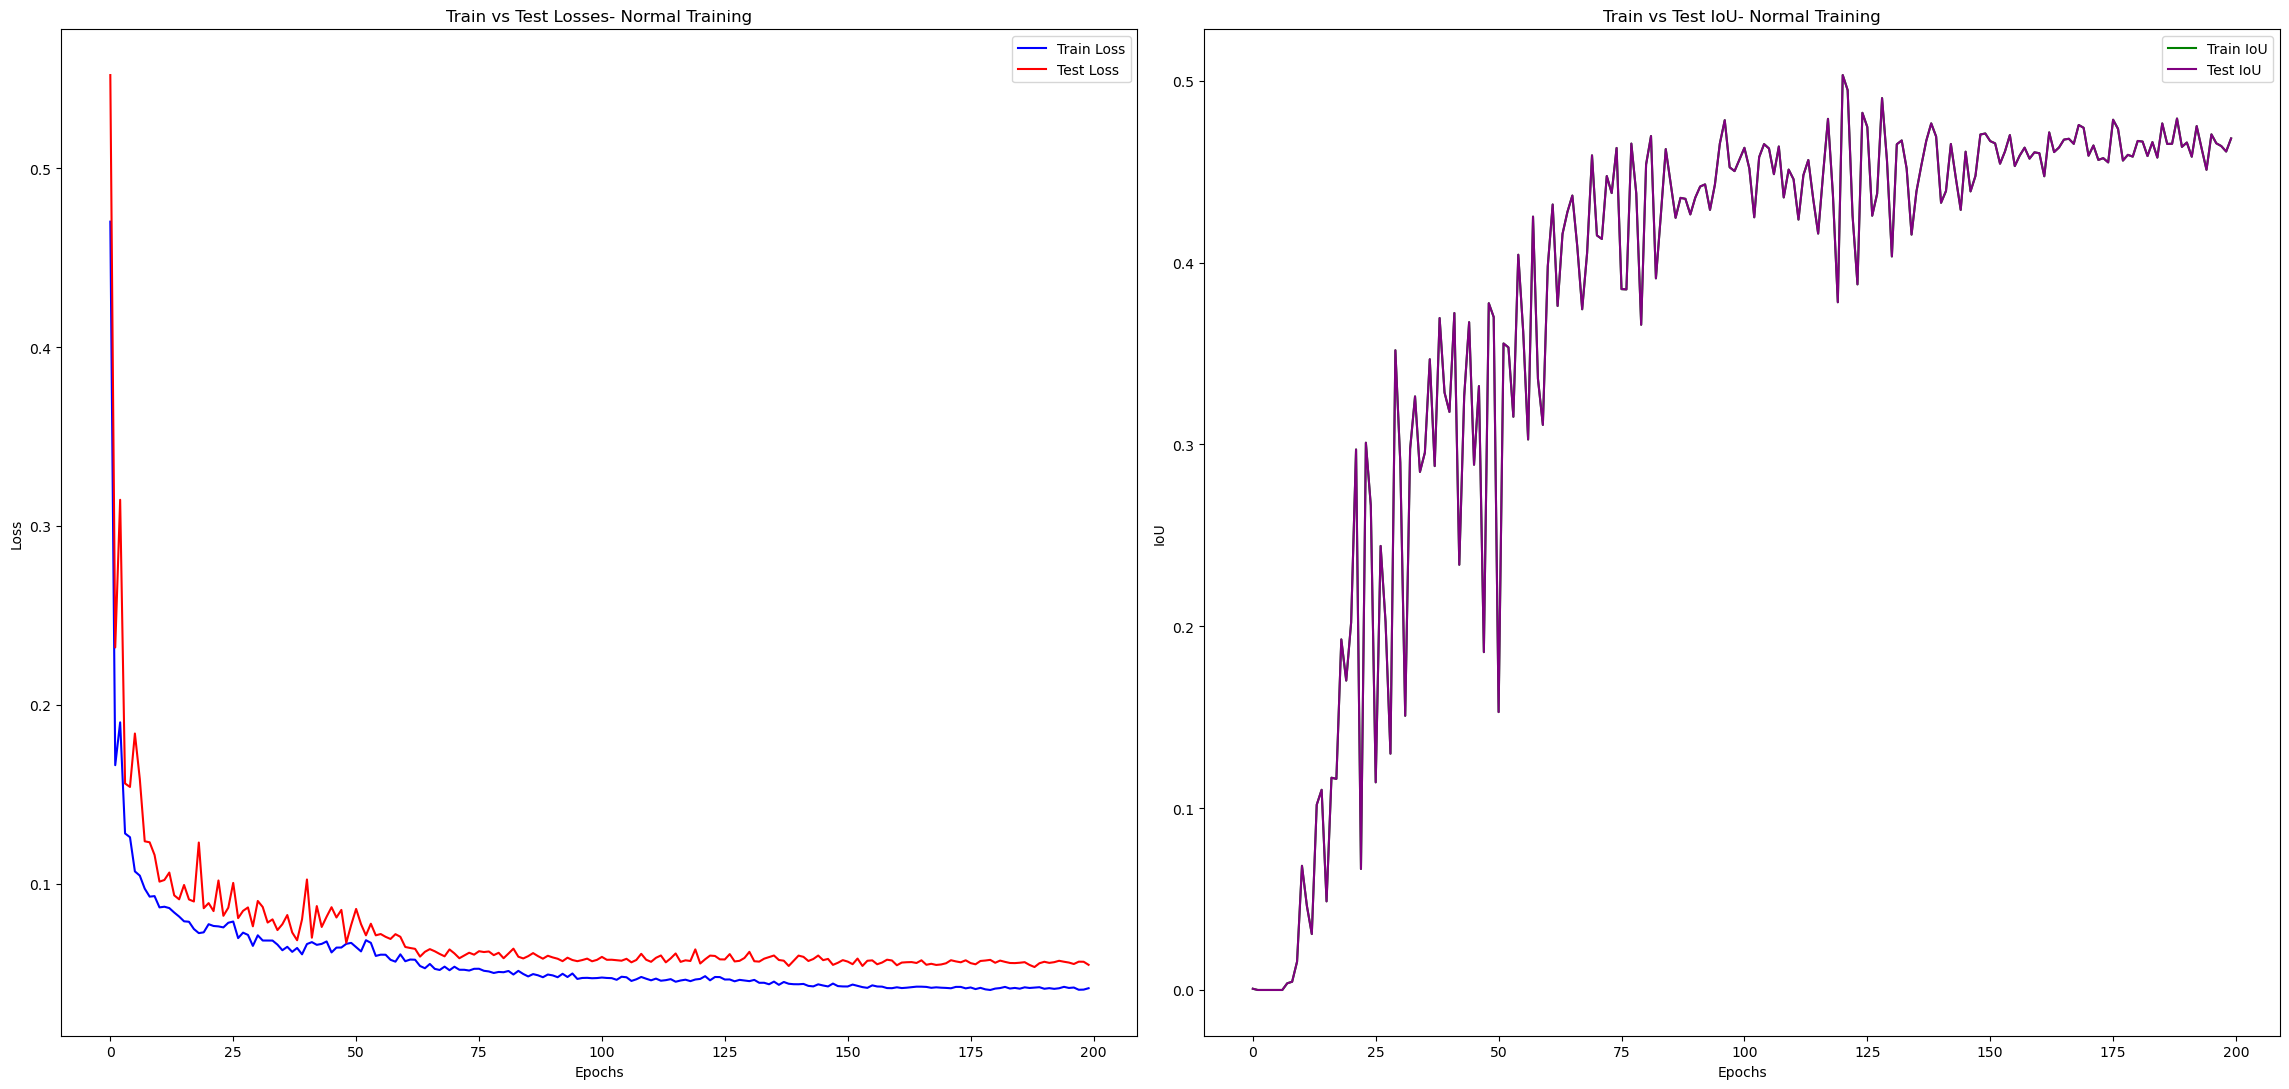

In [35]:
plot_metrics(normal_train_losses, 
             normal_test_losses, 
             normal_test_accuracies,
             normal_test_ious,
             title='- Normal Training')

In [36]:
# Gradient optimization model training

# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []
test_ious = []

num_epochs = 50

# Model Initialization
grad_model = CustomResNet(num_classes=2).cuda() 
training_loop(grad_model, 
              train_loader, 
              test_loader, 
              num_epochs, 
              train_losses, 
              test_losses, 
              test_accuracies, 
              test_ious,
              lr=1e-4,
              weight_decay=1e-4,
              model_path= "/home/fonta42/Desktop/interpretacao-redes-neurais/models/gradient_optimization_vessels/",
              gradient_optimization = True,
              optim_idx = 1)

KeyboardInterrupt: 

In [ ]:
plot_metrics(train_losses, 
             test_losses, 
             test_accuracies,
             test_ious,
             title='- Gradient Optimization Training',
             optimization_epochs=9)

NameError: name 'train_losses' is not defined